In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

prices = pd.read_excel('data/prices.xlsx', header=0, index_col=0)
prices_may = pd.read_excel('data/prices_end_may.xlsx', header=0, index_col=0)
display(prices.head())

,Category,1950,1951,1952,1953,1954,1955,1956,1957,1958,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Château Lafite Rothschild Pauillac,Premier cru 1855,671.0,1133.0,284.0,2666.0,574.0,668.0,432.0,618.0,310.0,...,712,498,511.0,485.0,563.0,584.0,835.0,516.0,NaN,NaN
Château Latour Pauillac,Premier cru 1855,445.0,442.0,328.0,442.0,860.0,658.0,525.0,466.0,418.0,...,1229,495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Château Mouton Rothschild Pauillac,Premier cru 1855,982.0,1013.0,439.0,817.0,1842.0,1082.0,688.0,539.0,676.0,...,709,430,472.0,376.0,409.0,552.0,611.0,NaN,NaN,NaN
Château Margaux,Premier cru 1855,316.0,NaN,328.0,997.0,645.0,514.0,361.0,259.0,364.0,...,625,384,404.0,389.0,409.0,1228.0,566.0,347.0,NaN,NaN
Château Haut-Brion Pessac-léognan,Premier cru 1855,510.0,883.0,368.0,837.0,685.0,1005.0,286.0,424.0,282.0,...,710,368,327.0,337.0,340.0,556.0,583.0,NaN,NaN,NaN


# Exploring data

## Exploring price data

To get the first feel of the data, I will plot the Premiers Crus from Medoc, from the 1855 ranking.

,Chateau,Vintage,Price
345,Château Haut-Brion Pessac-léognan,2015,556.0
346,Château Haut-Brion Pessac-léognan,2016,583.0
347,Château Haut-Brion Pessac-léognan,2017,NaN
348,Château Haut-Brion Pessac-léognan,2018,NaN
349,Château Haut-Brion Pessac-léognan,2019,NaN


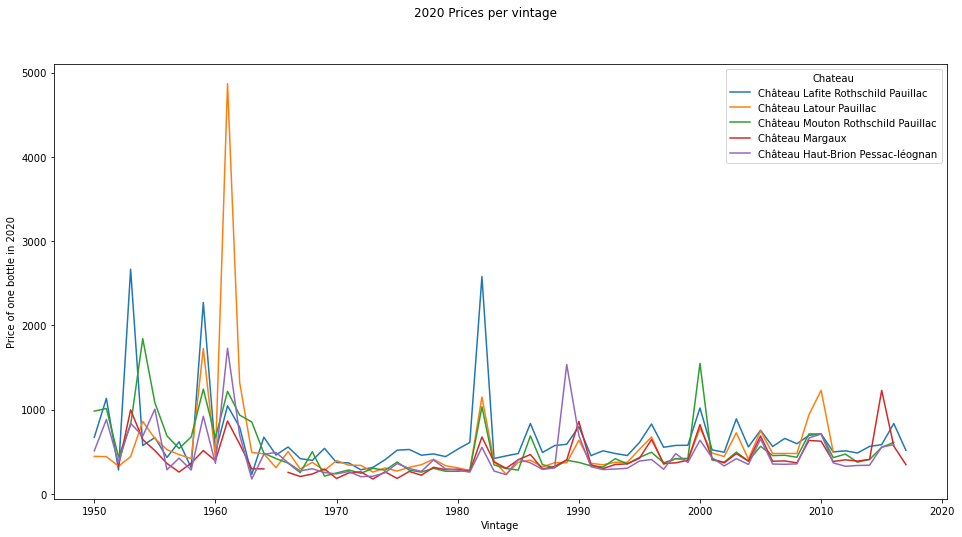

In [114]:
premiers = prices[(prices['Category'].isin(['Premier cru 1855']))].drop('Category', axis=1).transpose()
premiers = premiers.replace(-100, np.NaN)
premiers = premiers.reset_index()
premiers = premiers.melt(id_vars='index').rename(columns={'index':'Vintage', 'variable':'Chateau', 'value':'Price'})[['Chateau','Vintage','Price']]

premiers['Vintage'] = premiers['Vintage'].astype(int)

display(premiers.tail())

plt.figure(figsize=(16,8))
plot = sns.lineplot(data=premiers, x='Vintage', y='Price', hue='Chateau')
plt.ylabel('Price of one bottle in 2020')
plt.xlabel('Vintage')
plt.suptitle('2020 Prices per vintage')
plt.show()

Bear in mind that we have on the x-axis, not years on which prices were measured for the same bottle, but the different vintage for which we recorded the 2020 prices. The prices explode on the good years, which makes the rest of their variation harder to see. Let us approach this with a different function.

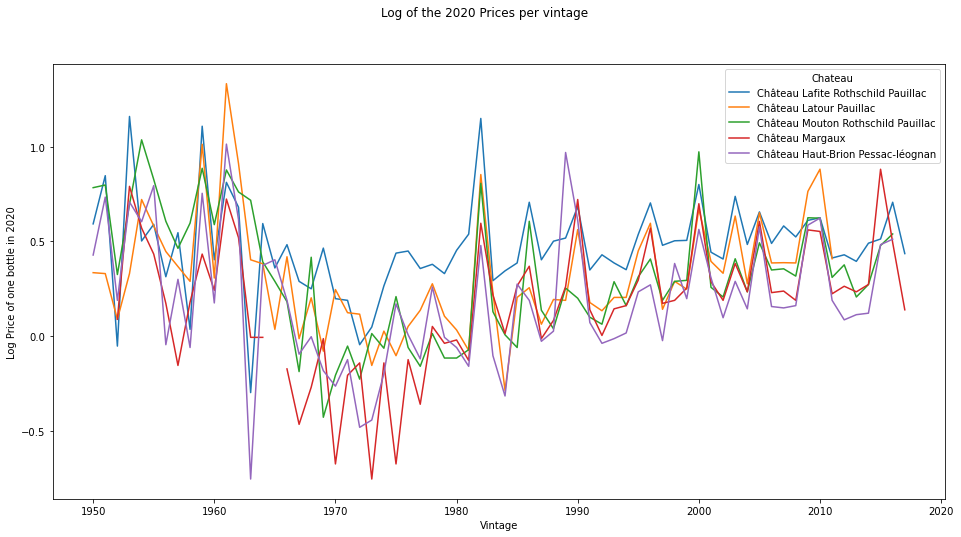

In [115]:
#Creating a strange price function will help distinguish trends
premiers['Log Price'] = np.log(np.log(premiers['Price'])- 4.7)

plt.figure(figsize=(16,8))
plot = sns.lineplot(data=premiers, x='Vintage', y='Log Price', hue='Chateau')
plt.ylabel('Log Price of one bottle in 2020')
plt.xlabel('Vintage')
plt.suptitle('Log of the 2020 Prices per vintage')
plt.show()

The variations appear more clearly here. It seems that wine prices today decline for bottles from the vintage 1950 to the 1970 vintage, which is coherent with the fact that aging wine gains a collectible value. But after that, the prices rise, which could be due to improving winemaking techniques, a positive trend in weather, or a wine price bubble. The different wines from the sample behave quit consistently.

## Selecting our wine sample

So far, I've considered only the 1855 Premiers crus (First Growth). But I want to include other wines to have a more consistent sample. Where to get them? I have a sample of Saint-Emilion Premiers Crus and 1855 seconds crus.
I will rank them based on their price, for vintages later than 1980.

Avg absolute relative price diff 0.035
['Le Pin Pomerol', 'Château Lafite Rothschild Pauillac', 'Château Lafleur Pomerol', 'Château Mouton Rothschild Pauillac', 'Château Latour Pauillac', 'Château Cheval Blanc', 'Château Ausone', 'Château Haut-Brion Pessac-léognan', 'Château Margaux', 'Château Angélus', 'Château Trotte Vieille', 'Château Palmer', 'Petrus Pomerol', 'Château Pavie', 'Château Léoville Las Cases Saint-Julien', 'Château Figeac', 'Château Pichon-Longueville Comtesse de Lalande Pauillac', 'Château Ducru-Beaucaillou Saint-Julien', 'Château Montrose Saint-Estèphe', 'Château Pichon-Longueville Baron Pauillac', 'Château Léoville Barton Saint-Julien', 'Château Léoville Poyferré Saint-Julien', 'Château Gruaud Larose Saint-Julien', 'Château Canon', 'Château Rauzan-Ségla Margaux', 'Clos Fourtet', 'Château Magdelaine', 'Chateau Beausejour Duffau-Lagarrosse', 'Château la Gaffeliere-Naudes', 'Château Brane-Cantenac Margaux']


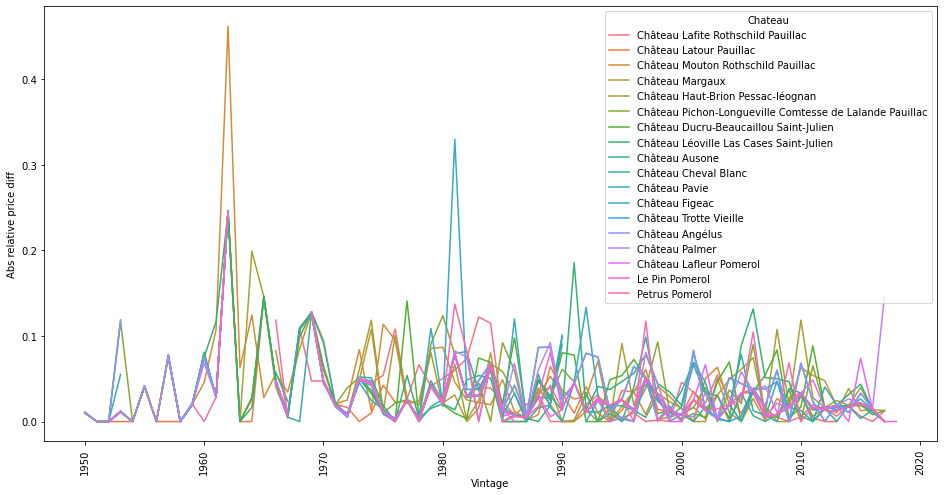

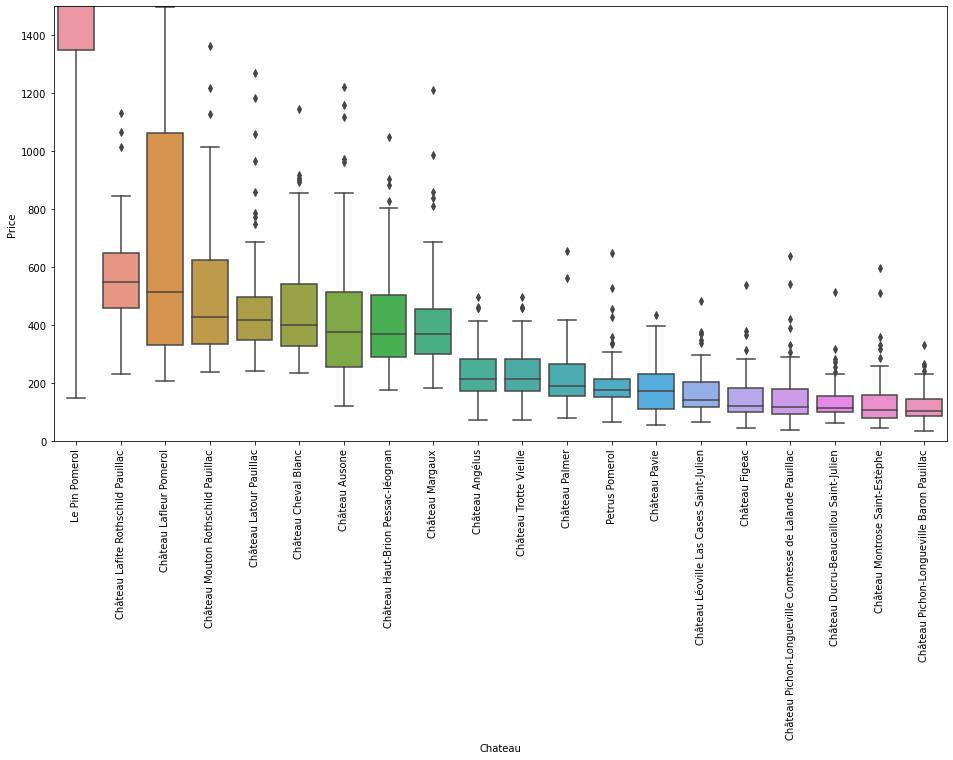

In [122]:
df_dec = prices.drop('Category', axis=1).transpose().reset_index().melt(id_vars='index').rename(columns={'index':'Vintage', 'variable':'Chateau', 'value':'Price'})[['Chateau','Vintage','Price']]
df_dec = df_dec.replace(-100, np.NaN)
df_may = prices_may.drop('Category', axis=1).transpose().reset_index().melt(id_vars='index').rename(columns={'index':'Vintage', 'variable':'Chateau', 'value':'Price'})[['Chateau','Vintage','Price']]
df_may = df_may.replace(-100, np.NaN)


#Combine both databases
df = df_dec
df['Price dec'] = df_dec['Price']
df['Price may'] = df_may['Price']
df['Price'] = df.apply(
    lambda row: row['Price may'] if (pd.isnull(row['Price dec']) and not pd.isnull(row['Price may']))
        else (row['Price dec'] if (not pd.isnull(row['Price dec']) and pd.isnull(row['Price may']))
                 else (row['Price dec'] + row['Price may'])/2)
    , axis=1
)

df['Log Price'] = np.log(df['Price'])


df['Price diff'] = df_may['Price'] - df_dec['Price']
df['Relative price diff'] = df['Price diff'] / df['Price']
df['Abs relative price diff'] = np.abs(df['Relative price diff'])

print('Avg absolute relative price diff', round(np.mean(df['Abs relative price diff']), 3))


ranking = df.groupby('Chateau')['Price'].median().sort_values(ascending=False)
top_wines = ranking.index.to_list()[:30]
print(top_wines)

#Display prices differences for top wines
plt.figure(figsize=(16, 8))
sns.lineplot(data=df[(df['Chateau'].isin(top_wines[:18]))], x='Vintage', y='Abs relative price diff', hue='Chateau')
plt.xticks(rotation=90)
plt.show()




#Display boxplots of top wines from both rankings

plt.figure(figsize=(16, 8))
sns.boxplot(data=df[(df_dec['Chateau'].isin(top_wines[:20]))], x='Chateau', y='Price', order = top_wines[:20])
plt.xticks(rotation=90)
plt.ylim(0,1500)
plt.savefig('views/top_wines.png', bbox_inches='tight')
plt.show()



In [117]:
top_wines.remove('Le Pin Pomerol')
top_wines.remove('Château Lafleur Pomerol')

top_wines = top_wines[:15]
print(top_wines)

['Château Lafite Rothschild Pauillac', 'Château Mouton Rothschild Pauillac', 'Château Latour Pauillac', 'Château Cheval Blanc', 'Château Ausone', 'Château Haut-Brion Pessac-léognan', 'Château Margaux', 'Château Angélus', 'Château Trotte Vieille', 'Château Palmer', 'Petrus Pomerol', 'Château Pavie', 'Château Léoville Las Cases Saint-Julien', 'Château Figeac', 'Château Pichon-Longueville Comtesse de Lalande Pauillac']


C:\Users\Rico\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


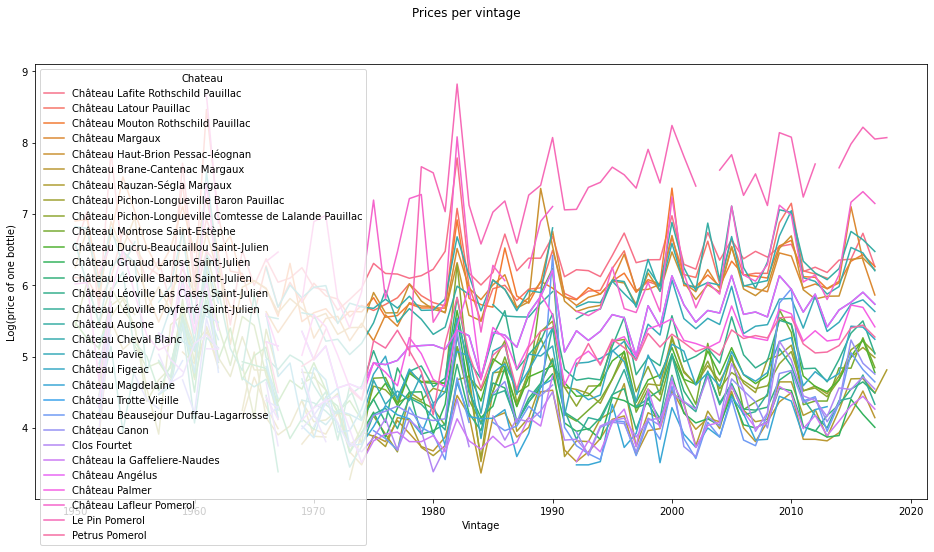

Series([], Name: Price, dtype: float64)
R2 between medoc and saint emilion: 0.35094491262781147
Spearman between medoc and saint emilion: 0.8527342931969829


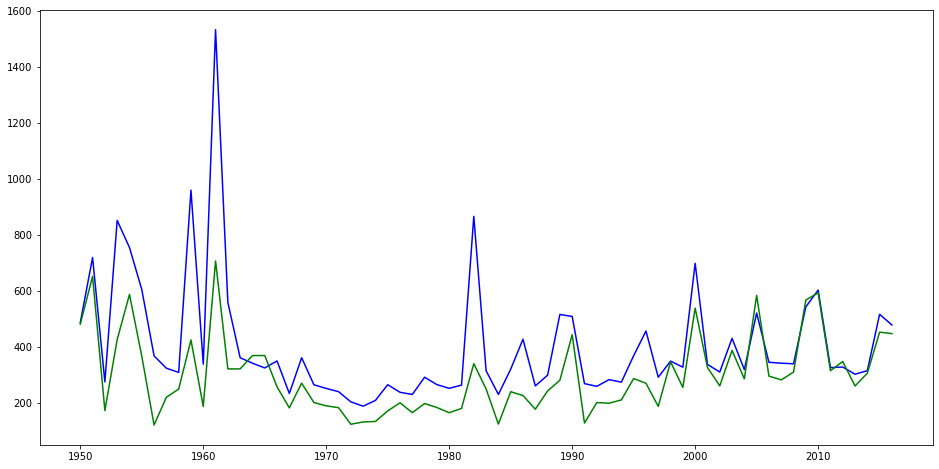

In [123]:
premiers = df[df['Chateau'].isin(top_wines)]
premiers.loc[:,'Log Price'] = np.log(premiers['Price'])
premiers.loc[:,'Vintage'] = premiers['Vintage'].astype(int)

plt.figure(figsize=(16,8))
sns.lineplot(data=premiers, x='Vintage', y='Log Price', hue='Chateau')
plt.ylabel('Log(price of one bottle)')
plt.xlabel('Vintage')
plt.suptitle('Prices per vintage')
plt.savefig('views/prices_per_vintage.png')
plt.show()



medoc = df[df['Chateau'].isin(['Château Lafite Rothschild Pauillac', 'Château Mouton Rothschild Pauillac', 'Château Latour Pauillac', 'Château Haut-Brion Pessac-léognan', 'Château Margaux', 'Château Palmer', 'Château Léoville Las Cases Saint-Julien', 'Château Pichon-Longueville Comtesse de Lalande Pauillac'])]
st_emilion = df[df['Chateau'].isin(['Château Cheval Blanc', 'Château Ausone','Château Angélus', 'Château Trotte Vieille','Château Pavie', 'Château Figeac'])]

avg_medoc = medoc.groupby('Vintage')['Price'].mean().loc[1950:2016].fillna(method='ffill')
avg_st_emilion = st_emilion.groupby('Vintage')['Price'].mean().loc[1950:2016].fillna(method='ffill')


plt.figure(figsize=(16,8))
plt.plot(avg_medoc, color='blue')
plt.plot(avg_st_emilion, color='green')
print(avg_st_emilion[avg_st_emilion.isnull()])

from sklearn.metrics import r2_score
from scipy.stats import spearmanr

print('R2 between medoc and saint emilion:', r2_score(avg_medoc, avg_st_emilion))
print('Spearman between medoc and saint emilion:', spearmanr(avg_medoc, avg_st_emilion)[0])

The wines of our sample have consistent variations.

In [85]:
average = premiers.groupby('Vintage')['Price'].mean().to_frame()

display(average.head())
average.reset_index().to_excel('data/generated_average_prices.xlsx', index=False)

,Price
Vintage,
1950,472.166667
1951,701.875000
1952,230.285714
1953,652.733333
1954,721.000000


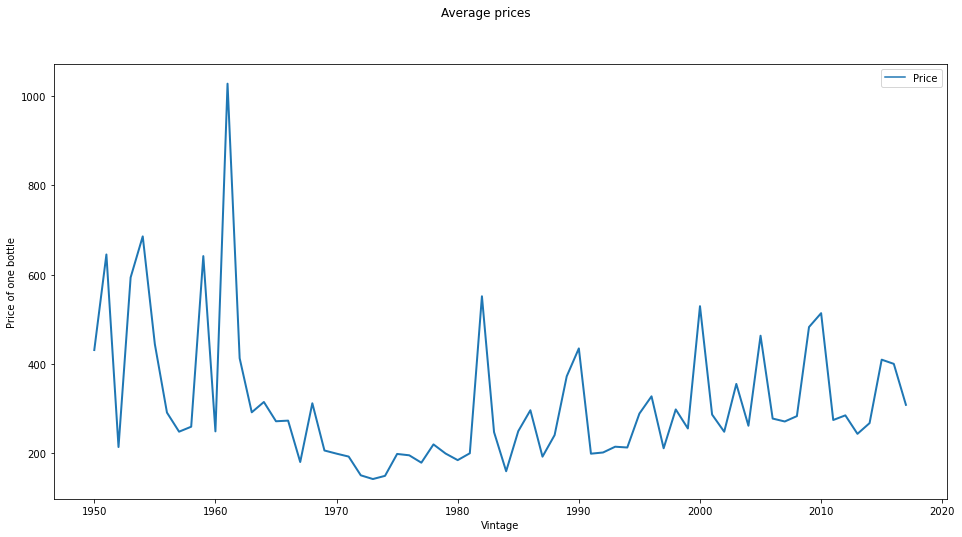

In [77]:
plt.figure(figsize=(16,8))
sns.lineplot(data=average, linewidth=2.0, color='black')

plt.ylabel('Price of one bottle')
plt.xlabel('Vintage')
plt.suptitle('Average prices')
plt.show()

# WA Ratings

In [14]:
ratings = pd.read_excel('data/ratings.xlsx')
display(ratings.head())

,Chateau,Category,Vintage,Rating - LB,Rating - HB,Date,Critic
0,Château Lafite Rothschild Pauillac,Premier cru 1855,1994,86,90,1995-04-01,Robert Parker
1,Château Lafite Rothschild Pauillac,Premier cru 1855,1995,92,95,1996-04-01,Robert Parker
2,Château Lafite Rothschild Pauillac,Premier cru 1855,1996,91,93,1997-04-01,Robert Parker
3,Château Lafite Rothschild Pauillac,Premier cru 1855,1997,90,93,1998-04-01,Robert Parker
4,Château Lafite Rothschild Pauillac,Premier cru 1855,1998,91,94,1999-04-01,Robert Parker


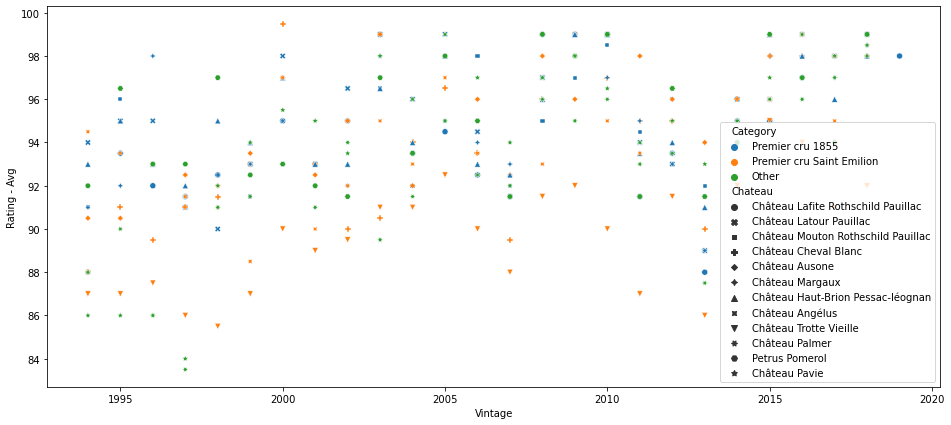

In [15]:
plt.figure(figsize=(16,7))
ratings['Rating - Avg'] = (ratings['Rating - LB'] + ratings['Rating - HB'])/2
sns.scatterplot(data=ratings, x='Vintage', y='Rating - Avg',hue='Category', style='Chateau')
plt.savefig('views/RP_ratings.png', bbox_inches='tight')

In [16]:
average_ratings = ratings.groupby('Vintage')['Rating - Avg'].mean().to_frame()
display(average_ratings.head(20))
average_ratings.to_excel('data/generated_average_ratings.xlsx')

,Rating - Avg
Vintage,
1994,90.250000
1995,92.166667
1996,91.583333
1997,89.875000
1998,91.750000
1999,92.041667
2000,95.583333
2001,92.125000
2002,93.083333


## Filtering input

Maybe we want to filter out the global trend, that is probably due at least in part to parasitic market effects not related to the wine quality. 

About this trend, see for example http://winegourd.blogspot.com/2020/07/the-outrageous-prices-of-modern-high.html.


Now, the goal here is to even out the global trend by filtering the price range into a trend and a residual component.

In [ ]:
import statsmodels.api as sm

average = premiers.groupby('Vintage')[['Price']].mean().dropna(axis=0)
average['Log Price'] = np.log(average['Price'])


# Try a Hodrick Prescott filter
average['HP filter'] = sm.tsa.filters.hpfilter(average['Log Price'], lamb=1000)[1]

fit = np.polyfit(average.index,average['Log Price'], 4)
poly = np.poly1d(fit)
average['Polynomial fit on the whole range'] = poly(average.index)


#Also try versions of both filters on shorter period of time
average['HP filter on reduced range'] = sm.tsa.filters.hpfilter(average['Log Price'][:40], lamb=1000)[1]
fit_short = np.polyfit(average.index[:40], average['Log Price'][:40], 4)
poly_short = np.poly1d(fit_short)

average['Polynomial fit on reduced range'] = np.nan
average.iloc[:40, -1] = poly_short(average.index[:40])


plt.figure(figsize=(16,8))
sns.lineplot(data=average[['Log Price','HP filter','Polynomial fit on the whole range','HP filter on reduced range','Polynomial fit on reduced range']])
plt.suptitle('Comparing simple polynomial fit and HP filter')
plt.show()


# Fit a polynomial to the HP filtered data
fit_hp = np.polyfit(average.index, average['HP filter'], 15)
poly_hp = np.poly1d(fit_hp)
average['Polynomial fit on HP filter'] = poly_hp(average.index)

plt.figure(figsize=(16,8))
sns.lineplot(data=average[['Log Price','HP filter', 'Polynomial fit on HP filter']])
plt.suptitle('Polynomial fit on HP filter')
plt.show()
display(average)
#Checking how fast our new polynomial diverges
plt.figure(figsize=(16,8))
sns.lineplot(x= range(1950, 2030), y=poly_hp(range(1950, 2030)), color='orange')
sns.lineplot(x= range(1950, 2018), y=average['Log Price'], color='black')
plt.suptitle('Continuing the polynomial to test its stability on the next unseen years')
plt.show()


In [ ]:
average['Corrected Log Price'] = average['Log Price'] - average['Polynomial fit on HP filter']

average[['Price','Log Price','Corrected Log Price']].reset_index().to_excel('data/generated_average_prices.xlsx', index=False)

The previous graphs show several outputs. First, fitting a polynomial gave good fits on a 50y+ range of time, but poorer results on shorter periods, whereas HP filter result was not impacted as deeply by a change in length. Thus, the best solution to get a time range-agnostic trend is fitting a polynomial on the HP filter. We will use this technique from now on.

# RP Ratings vs Price

In [ ]:
ratings = pd.read_excel('data/ratings.xlsx')
display(ratings.head())

plt.figure(figsize=(16,8))
sns.lineplot(data=ratings, x='Vintage',y='RP Rating', hue='Chateau')
plt.show()

In [ ]:
sample = premiers[(premiers['Chateau'].isin(['Château Latour Pauillac','Château Lafite Rothschild Pauillac']))&(premiers['Vintage']>=1989)&(premiers['Vintage']<=2013)]
sample['Corrected Log Price'] = sample['Log Price'] - poly_hp(sample['Vintage'])

sns.lineplot(data=sample, x='Vintage', y='Log Price')
plt.show()
sns.lineplot(data=sample, x='Vintage', y='Corrected Log Price')
plt.show()

sample = sample.sort_values(['Chateau','Vintage']).reset_index()
ratings = ratings.sort_values(['Chateau','Vintage']).reset_index(drop=True)
sample['Rating'] = ratings['RP Rating']

In [ ]:
plt.figure(figsize=(16,3))
sns.lineplot(data=sample, x='Vintage', y='Log Price', hue='Chateau')
plt.show()

plt.figure(figsize=(16,3))
sns.lineplot(data=sample, x='Vintage', y='Corrected Log Price', hue='Chateau')
plt.show()

plt.figure(figsize=(16,3))
sns.lineplot(data=sample, x='Vintage', y='Rating', hue='Chateau')
plt.show()

In [ ]:
def scatter_text(data, x, y, hue, text_column):
    """Scatter plot with country codes on the x y coordinates
       Based on this answer: https://stackoverflow.com/a/54789170/2641825"""
    # Create the scatter plot
    plt.figure(figsize=(16,8))

    p1 = sns.scatterplot(x, y, data=data, size = 8, legend=False, hue=hue)
    # Add text besides each point
    for line in range(0,data.shape[0]):
         p1.text(data[x][line]+0.01, data[y][line], 
                 data[text_column][line], horizontalalignment='left', 
                 size='medium', color='black', weight='semibold')
    # Set title and axis labels
    return p1
p1 = scatter_text(sample, 'Log Price', 'Rating', 'Chateau','Vintage')
plt.suptitle('Log Price vs Rating')
plt.show()

p2 = scatter_text(sample, 'Corrected Log Price', 'Rating', 'Chateau','Vintage')
plt.suptitle('Corrected Log Price vs Rating')
plt.show()

It seems that our correction of price was not relevant, because the Corrected Log Price is less coherent with the ratings. 
Maybe the recent price increase trend is indeed linked to a quality increase.